In [1]:
import fastai

In [2]:
from datasets import load_dataset
from fastai.tabular.all import *
from huggingface_hub import from_pretrained_fastai,  push_to_hub_fastai, notebook_login
from scipy.interpolate import interp1d
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

In [3]:
import datasets

datasets.logging.set_verbosity_error()

In [4]:
top_tagging_ds = load_dataset("dl4phys/top_tagging")

C:\Users\amiru\anaconda3\envs\tf-gpu\lib\site-packages\huggingface_hub\utils\_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'dataset_info': token. Will not be supported from version '0.12'.
  warnings.warn(message, FutureWarning)


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
top_tagging_ds

DatasetDict({
    train: Dataset({
        features: ['E_0', 'PX_0', 'PY_0', 'PZ_0', 'E_1', 'PX_1', 'PY_1', 'PZ_1', 'E_2', 'PX_2', 'PY_2', 'PZ_2', 'E_3', 'PX_3', 'PY_3', 'PZ_3', 'E_4', 'PX_4', 'PY_4', 'PZ_4', 'E_5', 'PX_5', 'PY_5', 'PZ_5', 'E_6', 'PX_6', 'PY_6', 'PZ_6', 'E_7', 'PX_7', 'PY_7', 'PZ_7', 'E_8', 'PX_8', 'PY_8', 'PZ_8', 'E_9', 'PX_9', 'PY_9', 'PZ_9', 'E_10', 'PX_10', 'PY_10', 'PZ_10', 'E_11', 'PX_11', 'PY_11', 'PZ_11', 'E_12', 'PX_12', 'PY_12', 'PZ_12', 'E_13', 'PX_13', 'PY_13', 'PZ_13', 'E_14', 'PX_14', 'PY_14', 'PZ_14', 'E_15', 'PX_15', 'PY_15', 'PZ_15', 'E_16', 'PX_16', 'PY_16', 'PZ_16', 'E_17', 'PX_17', 'PY_17', 'PZ_17', 'E_18', 'PX_18', 'PY_18', 'PZ_18', 'E_19', 'PX_19', 'PY_19', 'PZ_19', 'E_20', 'PX_20', 'PY_20', 'PZ_20', 'E_21', 'PX_21', 'PY_21', 'PZ_21', 'E_22', 'PX_22', 'PY_22', 'PZ_22', 'E_23', 'PX_23', 'PY_23', 'PZ_23', 'E_24', 'PX_24', 'PY_24', 'PZ_24', 'E_25', 'PX_25', 'PY_25', 'PZ_25', 'E_26', 'PX_26', 'PY_26', 'PZ_26', 'E_27', 'PX_27', 'PY_27', 'PZ_27', 'E_28'

In [6]:
[len(top_tagging_ds["train"]), len(top_tagging_ds["test"]), len(top_tagging_ds["validation"])]


[1211000, 404000, 403000]

In [7]:
top_tagging_ds["train"][1000]

{'E_0': 177.47433471679688,
 'PX_0': -84.67046356201172,
 'PY_0': -37.82949447631836,
 'PZ_0': -151.31747436523438,
 'E_1': 102.58887481689453,
 'PX_1': -48.31947326660156,
 'PY_1': -26.13525390625,
 'PZ_1': -86.64094543457031,
 'E_2': 100.36636352539062,
 'PX_2': -46.67668914794922,
 'PY_2': -26.42949104309082,
 'PZ_2': -84.83027648925781,
 'E_3': 93.2517318725586,
 'PX_3': -29.142444610595703,
 'PY_3': -32.04061508178711,
 'PZ_3': -82.58330535888672,
 'E_4': 71.21575164794922,
 'PX_4': -33.10759735107422,
 'PY_4': -18.194442749023438,
 'PZ_4': -60.36996841430664,
 'E_5': 49.91706466674805,
 'PX_5': -23.63846778869629,
 'PY_5': -12.959173202514648,
 'PZ_5': -42.01185607910156,
 'E_6': 47.65469741821289,
 'PX_6': -22.15697479248047,
 'PY_6': -12.252413749694824,
 'PZ_6': -40.372230529785156,
 'E_7': 47.16474533081055,
 'PX_7': -21.443477630615234,
 'PY_7': -11.910395622253418,
 'PZ_7': -40.284400939941406,
 'E_8': 51.003841400146484,
 'PX_8': -15.978032112121582,
 'PY_8': -17.626579284

### Removing the top-quark fourth vector columhn and the ttv

In [8]:
top_tagging_ds = top_tagging_ds.remove_columns(["truthE", "truthPX", "truthPY", "truthPZ", "ttv"])

### Converting the dataset to pandas dataframe

In [9]:
top_tagging_ds.set_format("pandas")
train_df, test_df = top_tagging_ds["train"][:], top_tagging_ds["test"][:]


In [10]:
train_df.describe()

,E_0,PX_0,PY_0,PZ_0,E_1,PX_1,PY_1,PZ_1,E_2,PX_2,...,PZ_197,E_198,PX_198,PY_198,PZ_198,E_199,PX_199,PY_199,PZ_199,is_signal_new
count,1.211000e+06,1.211000e+06,1.211000e+06,1.211000e+06,1.211000e+06,1.211000e+06,1.211000e+06,1.211000e+06,1.211000e+06,1.211000e+06,...,1211000.0,1211000.0,1211000.0,1211000.0,1211000.0,1211000.0,1211000.0,1211000.0,1211000.0,1.211000e+06
mean,2.332016e+02,-1.867086e-02,7.729669e-02,1.233673e-01,1.298056e+02,-3.271483e-02,4.602293e-02,-8.550970e-02,8.657201e+01,-5.269594e-02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.999810e-01
std,1.730499e+02,1.216729e+02,1.216562e+02,2.339332e+02,8.215803e+01,6.514657e+01,6.515224e+01,1.229249e+02,5.167919e+01,4.277317e+01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.000002e-01
min,2.374320e+01,-6.170629e+02,-6.343094e+02,-1.987190e+03,0.000000e+00,-2.999187e+02,-3.003196e+02,-9.755008e+02,0.000000e+00,-1.796854e+02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00
25%,1.246912e+02,-8.273960e+01,-8.265147e+01,-9.773817e+01,7.694183e+01,-4.967212e+01,-4.956618e+01,-5.913123e+01,5.074119e+01,-3.411882e+01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00
50%,1.821814e+02,-1.638192e-01,9.169528e-02,-5.053419e-02,1.075503e+02,-1.030243e-01,4.001390e-02,-4.200717e-02,7.350758e+01,-1.104440e-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00
75%,2.803688e+02,8.269467e+01,8.287092e+01,9.775138e+01,1.564566e+02,4.958123e+01,4.967238e+01,5.903098e+01,1.056562e+02,3.401901e+01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000e+00
max,2.183860e+03,6.437772e+02,6.069399e+02,2.094136e+03,1.101110e+03,2.975761e+02,2.917211e+02,1.059276e+03,6.333411e+02,1.879539e+02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000e+00


### From data to DataLoaders

In [11]:
# Downsample to ~0.5 if you're running on Colab / Kaggle which have limited RAM
frac_of_samples = 1.0
train_df = train_df.sample(int(frac_of_samples * len(train_df)), random_state=42)

features = list(train_df.drop(columns=["is_signal_new"]).columns)
splits = RandomSplitter(valid_pct=0.20, seed=42)(range_of(train_df))

dls = TabularDataLoaders.from_df(
    df=train_df,
    cont_names=features,
    y_names="is_signal_new",
    y_block=CategoryBlock,
    splits=splits,
    bs=1024,
)

In [12]:
dls.show_batch()

,E_0,PX_0,PY_0,PZ_0,E_1,PX_1,PY_1,PZ_1,E_2,PX_2,PY_2,PZ_2,E_3,PX_3,PY_3,PZ_3,E_4,PX_4,PY_4,PZ_4,E_5,PX_5,PY_5,PZ_5,E_6,PX_6,PY_6,PZ_6,E_7,PX_7,PY_7,PZ_7,E_8,PX_8,PY_8,PZ_8,E_9,PX_9,PY_9,PZ_9,E_10,PX_10,PY_10,PZ_10,E_11,PX_11,PY_11,PZ_11,E_12,PX_12,PY_12,PZ_12,E_13,PX_13,PY_13,PZ_13,E_14,PX_14,PY_14,PZ_14,E_15,PX_15,PY_15,PZ_15,E_16,PX_16,PY_16,PZ_16,E_17,PX_17,PY_17,PZ_17,E_18,PX_18,PY_18,PZ_18,E_19,PX_19,PY_19,PZ_19,E_20,PX_20,PY_20,PZ_20,E_21,PX_21,PY_21,PZ_21,E_22,PX_22,PY_22,PZ_22,E_23,PX_23,PY_23,PZ_23,E_24,PX_24,PY_24,PZ_24,E_25,PX_25,PY_25,PZ_25,E_26,PX_26,PY_26,PZ_26,E_27,PX_27,PY_27,PZ_27,E_28,PX_28,PY_28,PZ_28,E_29,PX_29,PY_29,PZ_29,E_30,PX_30,PY_30,PZ_30,E_31,PX_31,PY_31,PZ_31,E_32,PX_32,PY_32,PZ_32,E_33,PX_33,PY_33,PZ_33,E_34,PX_34,PY_34,PZ_34,E_35,PX_35,PY_35,PZ_35,E_36,PX_36,PY_36,PZ_36,E_37,PX_37,PY_37,PZ_37,E_38,PX_38,PY_38,PZ_38,E_39,PX_39,PY_39,PZ_39,E_40,PX_40,PY_40,PZ_40,E_41,PX_41,PY_41,PZ_41,E_42,PX_42,PY_42,PZ_42,E_43,PX_43,PY_43,PZ_43,E_44,PX_44,PY_44,PZ_44,E_45,PX_45,PY_45,PZ_45,E_46,PX_46,PY_46,PZ_46,E_47,PX_47,PY_47,PZ_47,E_48,PX_48,PY_48,PZ_48,E_49,PX_49,PY_49,PZ_49,E_50,PX_50,PY_50,PZ_50,E_51,PX_51,PY_51,PZ_51,E_52,PX_52,PY_52,PZ_52,E_53,PX_53,PY_53,PZ_53,E_54,PX_54,PY_54,PZ_54,E_55,PX_55,PY_55,PZ_55,E_56,PX_56,PY_56,PZ_56,E_57,PX_57,PY_57,PZ_57,E_58,PX_58,PY_58,PZ_58,E_59,PX_59,PY_59,PZ_59,E_60,PX_60,PY_60,PZ_60,E_61,PX_61,PY_61,PZ_61,E_62,PX_62,PY_62,PZ_62,E_63,PX_63,PY_63,PZ_63,E_64,PX_64,PY_64,PZ_64,E_65,PX_65,PY_65,PZ_65,E_66,PX_66,PY_66,PZ_66,E_67,PX_67,PY_67,PZ_67,E_68,PX_68,PY_68,PZ_68,E_69,PX_69,PY_69,PZ_69,E_70,PX_70,PY_70,PZ_70,E_71,PX_71,PY_71,PZ_71,E_72,PX_72,PY_72,PZ_72,E_73,PX_73,PY_73,PZ_73,E_74,PX_74,PY_74,PZ_74,E_75,PX_75,PY_75,PZ_75,E_76,PX_76,PY_76,PZ_76,E_77,PX_77,PY_77,PZ_77,E_78,PX_78,PY_78,PZ_78,E_79,PX_79,PY_79,PZ_79,E_80,PX_80,PY_80,PZ_80,E_81,PX_81,PY_81,PZ_81,E_82,PX_82,PY_82,PZ_82,E_83,PX_83,PY_83,PZ_83,E_84,PX_84,PY_84,PZ_84,E_85,PX_85,PY_85,PZ_85,E_86,PX_86,PY_86,PZ_86,E_87,PX_87,PY_87,PZ_87,E_88,PX_88,PY_88,PZ_88,E_89,PX_89,PY_89,PZ_89,E_90,PX_90,PY_90,PZ_90,E_91,PX_91,PY_91,PZ_91,E_92,PX_92,PY_92,PZ_92,E_93,PX_93,PY_93,PZ_93,E_94,PX_94,PY_94,PZ_94,E_95,PX_95,PY_95,PZ_95,E_96,PX_96,PY_96,PZ_96,E_97,PX_97,PY_97,PZ_97,E_98,PX_98,PY_98,PZ_98,E_99,PX_99,PY_99,PZ_99,E_100,PX_100,PY_100,PZ_100,E_101,PX_101,PY_101,PZ_101,E_102,PX_102,PY_102,PZ_102,E_103,PX_103,PY_103,PZ_103,E_104,PX_104,PY_104,PZ_104,E_105,PX_105,PY_105,PZ_105,E_106,PX_106,PY_106,PZ_106,E_107,PX_107,PY_107,PZ_107,E_108,PX_108,PY_108,PZ_108,E_109,PX_109,PY_109,PZ_109,E_110,PX_110,PY_110,PZ_110,E_111,PX_111,PY_111,PZ_111,E_112,PX_112,PY_112,PZ_112,E_113,PX_113,PY_113,PZ_113,E_114,PX_114,PY_114,PZ_114,E_115,PX_115,PY_115,PZ_115,E_116,PX_116,PY_116,PZ_116,E_117,PX_117,PY_117,PZ_117,E_118,PX_118,PY_118,PZ_118,E_119,PX_119,PY_119,PZ_119,E_120,PX_120,PY_120,PZ_120,E_121,PX_121,PY_121,PZ_121,E_122,PX_122,PY_122,PZ_122,E_123,PX_123,PY_123,PZ_123,E_124,PX_124,PY_124,PZ_124,E_125,PX_125,PY_125,PZ_125,E_126,PX_126,PY_126,PZ_126,E_127,PX_127,PY_127,PZ_127,E_128,PX_128,PY_128,PZ_128,E_129,PX_129,PY_129,PZ_129,E_130,PX_130,PY_130,PZ_130,E_131,PX_131,PY_131,PZ_131,E_132,PX_132,PY_132,PZ_132,E_133,PX_133,PY_133,PZ_133,E_134,PX_134,PY_134,PZ_134,E_135,PX_135,PY_135,PZ_135,E_136,PX_136,PY_136,PZ_136,E_137,PX_137,PY_137,PZ_137,E_138,PX_138,PY_138,PZ_138,E_139,PX_139,PY_139,PZ_139,E_140,PX_140,PY_140,PZ_140,E_141,PX_141,PY_141,PZ_141,E_142,PX_142,PY_142,PZ_142,E_143,PX_143,PY_143,PZ_143,E_144,PX_144,PY_144,PZ_144,E_145,PX_145,PY_145,PZ_145,E_146,PX_146,PY_146,PZ_146,E_147,PX_147,PY_147,PZ_147,E_148,PX_148,PY_148,PZ_148,E_149,PX_149,PY_149,PZ_149,E_150,PX_150,PY_150,PZ_150,E_151,PX_151,PY_151,PZ_151,E_152,PX_152,PY_152,PZ_152,E_153,PX_153,PY_153,PZ_153,E_154,PX_154,PY_154,PZ_154,E_155,PX_155,PY_155,PZ_155,E_156,PX_156,PY_156,PZ_156,E_157,PX_157,PY_157,PZ_157,E_158,PX_158,PY_158,PZ_158,E_159,PX_159,PY_159,PZ_159,E_160,PX_160,PY_160,PZ_160,E_161,PX_161,PY_161,PZ_161,E_162,PX_162,PY_162,PZ_162,E_163,PX_163,PY_163,PZ_163,E_164,PX_16

### Create a Learner

In [13]:
learn1 = tabular_learner(
        dls, layers=[200, 200, 50, 50], metrics = [accuracy, RocAucBinary()])

In [14]:
learn1.summary()

TabularModel (Input shape: 1024 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     1024 x 800          
BatchNorm1d                               1600       True      
____________________________________________________________________________
                     1024 x 200          
Linear                                    160000     True      
ReLU                                                           
BatchNorm1d                               400        True      
Linear                                    40000      True      
ReLU                                                           
BatchNorm1d                               400        True      
____________________________________________________________________________
                     1024 x 50           
Linear                                    10000      True      
ReLU                                                           
BatchNorm1d                               1

In [15]:
learn1_1 = tabular_learner(
        dls, layers=[200, 200, 200, 50, 50], metrics = [accuracy, RocAucBinary()])

In [16]:
learn1_1.summary()

TabularModel (Input shape: 1024 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     1024 x 800          
BatchNorm1d                               1600       True      
____________________________________________________________________________
                     1024 x 200          
Linear                                    160000     True      
ReLU                                                           
BatchNorm1d                               400        True      
Linear                                    40000      True      
ReLU                                                           
BatchNorm1d                               400        True      
Linear                                    40000      True      
ReLU                                                           
BatchNorm1d                               400        True      
____________________________________________________________________________
                     

In [17]:
learn1_2 = tabular_learner(
        dls, layers=[200, 200, 200, 50, 50, 50], metrics = [accuracy, RocAucBinary()])

In [18]:
learn1_2.summary()

TabularModel (Input shape: 1024 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     1024 x 800          
BatchNorm1d                               1600       True      
____________________________________________________________________________
                     1024 x 200          
Linear                                    160000     True      
ReLU                                                           
BatchNorm1d                               400        True      
Linear                                    40000      True      
ReLU                                                           
BatchNorm1d                               400        True      
Linear                                    40000      True      
ReLU                                                           
BatchNorm1d                               400        True      
____________________________________________________________________________
                     

In [19]:
learn2 = tabular_learner(
        dls, layers=[200], metrics = [accuracy, RocAucBinary()])

In [20]:
learn2.summary()

TabularModel (Input shape: 1024 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     1024 x 800          
BatchNorm1d                               1600       True      
____________________________________________________________________________
                     1024 x 200          
Linear                                    160000     True      
ReLU                                                           
BatchNorm1d                               400        True      
____________________________________________________________________________
                     1024 x 2            
Linear                                    402        True      
____________________________________________________________________________

Total params: 162,402
Total trainable params: 162,402
Total non-trainable params: 0

Optimizer used: <function Adam at 0x0000016D31D2F1C0>
Loss function: FlattenedLoss of CrossEntropyLoss()

Callbacks:
  - TrainEvalCallba

In [21]:
learn2_1 = tabular_learner(
        dls, layers=[800], metrics = [accuracy, RocAucBinary()])

In [22]:
learn2_1.summary()

TabularModel (Input shape: 1024 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     1024 x 800          
BatchNorm1d                               1600       True      
Linear                                    640000     True      
ReLU                                                           
BatchNorm1d                               1600       True      
____________________________________________________________________________
                     1024 x 2            
Linear                                    1602       True      
____________________________________________________________________________

Total params: 644,802
Total trainable params: 644,802
Total non-trainable params: 0

Optimizer used: <function Adam at 0x0000016D31D2F1C0>
Loss function: FlattenedLoss of CrossEntropyLoss()

Callbacks:
  - TrainEvalCallback
  - CastToTensor
  - Recorder
  - ProgressCallback

In [23]:
learn2_2 = tabular_learner(
        dls, layers=[3200], metrics = [accuracy, RocAucBinary()])

In [24]:
learn2_2.summary()

TabularModel (Input shape: 1024 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     1024 x 800          
BatchNorm1d                               1600       True      
____________________________________________________________________________
                     1024 x 3200         
Linear                                    2560000    True      
ReLU                                                           
BatchNorm1d                               6400       True      
____________________________________________________________________________
                     1024 x 2            
Linear                                    6402       True      
____________________________________________________________________________

Total params: 2,574,402
Total trainable params: 2,574,402
Total non-trainable params: 0

Optimizer used: <function Adam at 0x0000016D31D2F1C0>
Loss function: FlattenedLoss of CrossEntropyLoss()

Callbacks:
  - TrainEvalCa

In [25]:
models = [learn1, learn1_1, learn1_2, learn2, learn2_1, learn2_2]

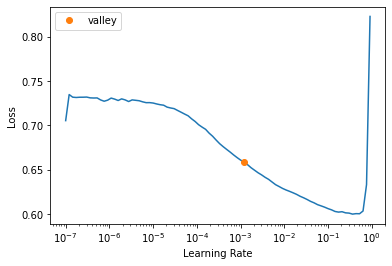

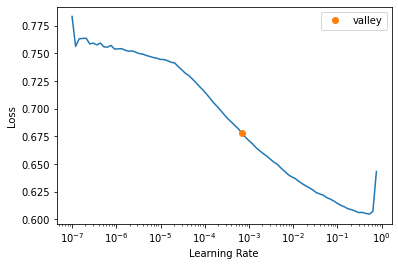

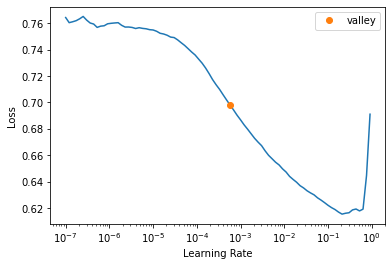

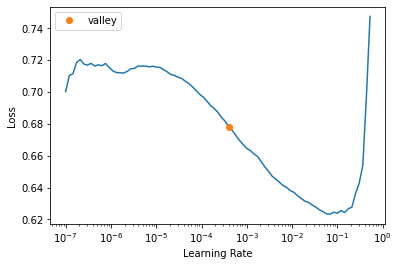

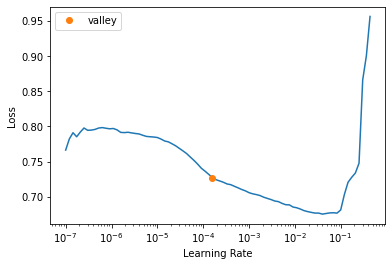

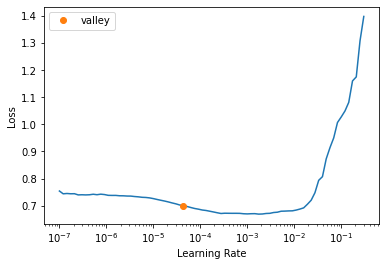

In [26]:
for i in models:
    i.lr_find()

In [27]:
lrates = [3e-1, 6e-1, 8e-1, 9e-1, 4e-2, 3e-4]

### Train the models

In [29]:
for i in range(len(models)):
    models[i].fit_one_cycle(n_epoch=50, lr_max=lrates[i])

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.512808,0.514775,0.731160,0.808191,00:36
1,0.481061,0.549359,0.712547,0.815087,00:36
2,0.475331,0.629768,0.699979,0.794914,00:35
3,0.478981,0.863231,0.720442,0.799136,00:36
4,0.491243,8.647140,0.730553,0.815744,00:36
5,0.491150,0.553965,0.714624,0.786497,00:36
6,0.525640,728.228943,0.623567,0.787677,00:37
7,0.517608,0.685929,0.676391,0.810123,00:36
8,0.543041,64978968.000000,0.713022,0.793203,00:38
9,0.532055,1070677.125000,0.710834,0.791495,00:36


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.523330,0.528851,0.725050,0.787088,00:39
1,0.523103,0.570333,0.715813,0.785223,00:39
2,0.522067,0.635561,0.714137,0.784725,00:39
3,0.539879,0.576968,0.720153,0.784030,00:39
4,0.507905,1.273571,0.741391,0.827383,00:39
5,0.464441,0.484473,0.751854,0.851011,00:40
6,0.467247,0.474233,0.766887,0.847324,00:39
7,0.536648,32384006144.000000,0.626003,0.783881,00:39
8,0.538794,605043904.000000,0.704368,0.775815,00:39
9,0.541930,76451365781504.000000,0.696057,0.785117,00:39


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.529353,0.543091,0.708456,0.791953,00:40
1,0.527076,0.529181,0.715739,0.798211,00:40
2,0.526855,0.553760,0.704372,0.777613,00:40
3,0.530081,0.523786,0.724224,0.795213,00:40
4,0.575838,39517440.000000,0.673625,0.775905,00:40
5,1.592261,3968302.750000,0.541346,0.600413,00:40
6,0.530749,0.532218,0.718902,0.791747,00:40
7,0.660903,80492275695616.000000,0.500178,0.778867,00:40
8,0.973410,1400434304.000000,0.500078,0.776086,00:41
9,1.735804,56780981796864.000000,0.500017,0.686342,00:41


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.539222,0.537446,0.714934,0.778135,00:32
1,0.533827,0.548576,0.699414,0.784911,00:32
2,0.559573,0.611722,0.711086,0.783736,00:32
3,0.555270,0.593623,0.707465,0.764775,00:32
4,0.601796,0.613003,0.708964,0.770438,00:33
5,0.587336,0.882755,0.706396,0.771389,00:33
6,4.238026,1.358881,0.526135,0.735271,00:33
7,2.081906,500.012909,0.500983,0.505124,00:32
8,1.561855,1.643987,0.499872,0.767617,00:33
9,2.504069,25.445473,0.500045,0.754865,00:33


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.533090,0.530109,0.721854,0.790238,00:50
1,0.512518,0.524683,0.718117,0.795721,00:50
2,0.502976,0.560391,0.715149,0.806111,00:49
3,0.500146,0.529385,0.723353,0.803900,00:50
4,0.499506,0.508344,0.732316,0.821459,00:49
5,0.495270,0.512968,0.729942,0.816985,00:49
6,0.498780,0.502792,0.743617,0.822472,00:49
7,0.506944,0.546829,0.700454,0.798129,00:49
8,0.505412,0.523466,0.735396,0.810681,00:49
9,0.500578,0.504509,0.738212,0.825314,00:50


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.531822,0.533359,0.720846,0.792695,01:55
1,0.514753,0.521976,0.730681,0.814529,01:56
2,0.493431,0.500402,0.756784,0.836340,01:55
3,0.464123,0.484839,0.783340,0.858442,01:55
4,0.446276,0.457285,0.802209,0.874863,01:56
5,0.433047,0.461790,0.803501,0.879150,01:56
6,0.419110,0.438732,0.811656,0.885404,01:56
7,0.407479,0.451790,0.820033,0.895347,01:56
8,0.407110,0.459921,0.811524,0.891579,01:56
9,0.393328,0.424295,0.823732,0.900936,01:55


### Evaluate the Models

In [31]:
test_dl1 = learn1.dls.test_dl(test_items=test_df)
test_dl1_1 = learn1_1.dls.test_dl(test_items=test_df)
test_dl1_2 = learn1_2.dls.test_dl(test_items=test_df)
test_dl2 = learn2.dls.test_dl(test_items=test_df)
test_dl2_1 = learn2_1.dls.test_dl(test_items=test_df)
test_dl2_2 = learn2_2.dls.test_dl(test_items=test_df)


In [32]:
preds1, targs1 = learn1.get_preds(dl=test_dl1)
preds1_1, targs1_1 = learn1_1.get_preds(dl=test_dl1_1)
preds1_2, targs1_2 = learn1_2.get_preds(dl=test_dl1_2)
preds2, targs2 = learn2.get_preds(dl=test_dl2)
preds2_1, targs2_1 = learn2_1.get_preds(dl=test_dl2_1)
preds2_2, targs2_2 = learn2_2.get_preds(dl=test_dl2_2)


In [33]:
preds1[:7], targs1[:7]


(tensor([[0.9982, 0.0018],
         [0.8519, 0.1481],
         [0.4079, 0.5921],
         [0.5931, 0.4069],
         [0.9068, 0.0932],
         [0.8460, 0.1540],
         [0.3549, 0.6451]]),
 tensor([[0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0]], dtype=torch.int8))

In [34]:
signal_test1 = preds1[:, 1][targs1.flatten() == 1].numpy()
background_test1 = preds1[:, 1][targs1.flatten() == 0].numpy()

signal_test1_1 = preds1_1[:, 1][targs1_1.flatten() == 1].numpy()
background_test1_1 = preds1_1[:, 1][targs1_1.flatten() == 0].numpy()

signal_test1_2 = preds1_2[:, 1][targs1_2.flatten() == 1].numpy()
background_test1_2 = preds1_2[:, 1][targs1_2.flatten() == 0].numpy()

signal_test2 = preds2[:, 1][targs2.flatten() == 1].numpy()
background_test2 = preds2[:, 1][targs2.flatten() == 0].numpy()

signal_test2_1 = preds2_1[:, 1][targs2_1.flatten() == 1].numpy()
background_test2_1 = preds2_1[:, 1][targs2_1.flatten() == 0].numpy()

signal_test2_2 = preds2_2[:, 1][targs2_2.flatten() == 1].numpy()
background_test2_2 = preds2_2[:, 1][targs2_2.flatten() == 0].numpy()





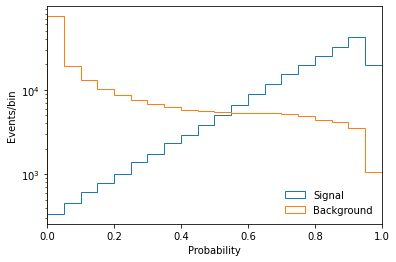

In [35]:
plt.hist(signal_test1, histtype="step", bins=20, range=(0, 1), label="Signal")
plt.hist(background_test1, histtype="step", bins=20, range=(0, 1), label="Background")
plt.xlabel("Probability")
plt.ylabel("Events/bin")
plt.yscale("log")
plt.xlim(0, 1)
plt.legend(loc="lower right", frameon=False)
plt.show()

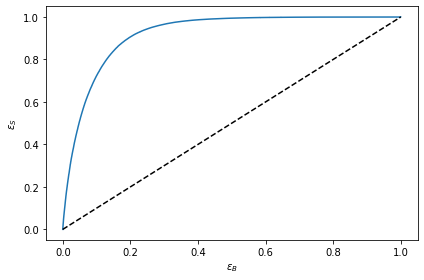

In [36]:
fpr, tpr, thresholds = roc_curve(y_true=targs1, y_score=preds1[:, 1])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], ls="--", color="k")
plt.xlabel(r"$\epsilon_B$")
plt.ylabel(r"$\epsilon_S$")
plt.tight_layout()

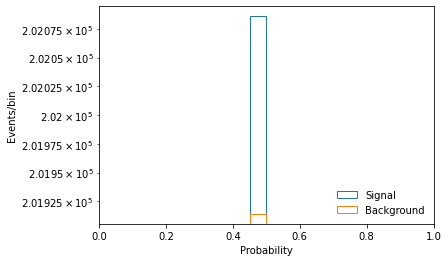

In [37]:
plt.hist(signal_test1_1, histtype="step", bins=20, range=(0, 1), label="Signal")
plt.hist(background_test1_1, histtype="step", bins=20, range=(0, 1), label="Background")
plt.xlabel("Probability")
plt.ylabel("Events/bin")
plt.yscale("log")
plt.xlim(0, 1)
plt.legend(loc="lower right", frameon=False)
plt.show()

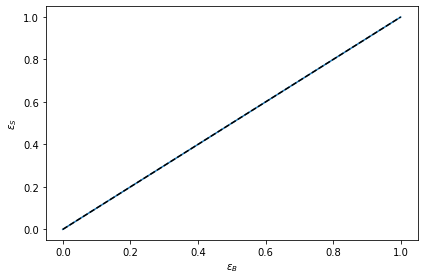

In [38]:
fpr, tpr, thresholds = roc_curve(y_true=targs1_1, y_score=preds1_1[:, 1])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], ls="--", color="k")
plt.xlabel(r"$\epsilon_B$")
plt.ylabel(r"$\epsilon_S$")
plt.tight_layout()

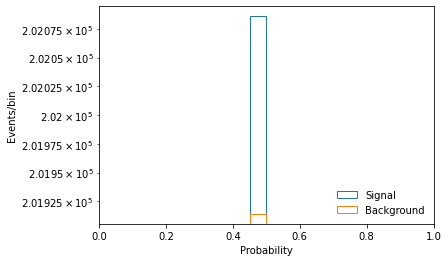

In [39]:
plt.hist(signal_test1_2, histtype="step", bins=20, range=(0, 1), label="Signal")
plt.hist(background_test1_2, histtype="step", bins=20, range=(0, 1), label="Background")
plt.xlabel("Probability")
plt.ylabel("Events/bin")
plt.yscale("log")
plt.xlim(0, 1)
plt.legend(loc="lower right", frameon=False)
plt.show()

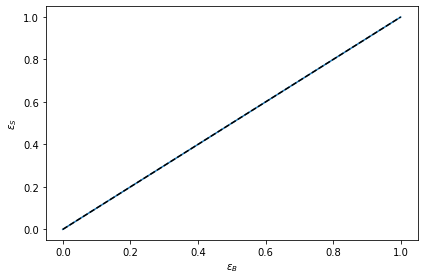

In [40]:
fpr, tpr, thresholds = roc_curve(y_true=targs1_2, y_score=preds1_2[:, 1])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], ls="--", color="k")
plt.xlabel(r"$\epsilon_B$")
plt.ylabel(r"$\epsilon_S$")
plt.tight_layout()

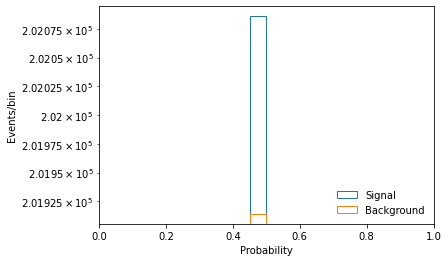

In [41]:
plt.hist(signal_test2, histtype="step", bins=20, range=(0, 1), label="Signal")
plt.hist(background_test2, histtype="step", bins=20, range=(0, 1), label="Background")
plt.xlabel("Probability")
plt.ylabel("Events/bin")
plt.yscale("log")
plt.xlim(0, 1)
plt.legend(loc="lower right", frameon=False)
plt.show()

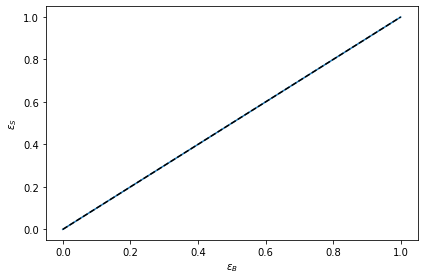

In [42]:
fpr, tpr, thresholds = roc_curve(y_true=targs2, y_score=preds2[:, 1])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], ls="--", color="k")
plt.xlabel(r"$\epsilon_B$")
plt.ylabel(r"$\epsilon_S$")
plt.tight_layout()

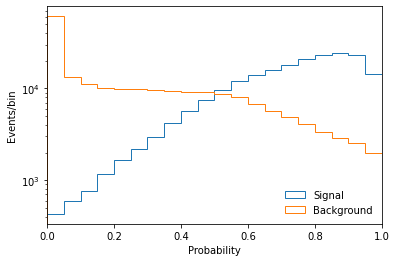

In [43]:
plt.hist(signal_test2_1, histtype="step", bins=20, range=(0, 1), label="Signal")
plt.hist(background_test2_1, histtype="step", bins=20, range=(0, 1), label="Background")
plt.xlabel("Probability")
plt.ylabel("Events/bin")
plt.yscale("log")
plt.xlim(0, 1)
plt.legend(loc="lower right", frameon=False)
plt.show()

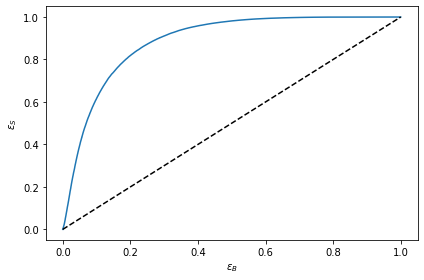

In [44]:
fpr, tpr, thresholds = roc_curve(y_true=targs2_1, y_score=preds2_1[:, 1])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], ls="--", color="k")
plt.xlabel(r"$\epsilon_B$")
plt.ylabel(r"$\epsilon_S$")
plt.tight_layout()

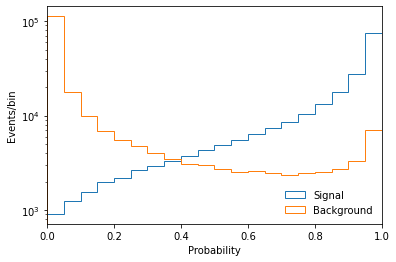

In [45]:
plt.hist(signal_test2_2, histtype="step", bins=20, range=(0, 1), label="Signal")
plt.hist(background_test2_2, histtype="step", bins=20, range=(0, 1), label="Background")
plt.xlabel("Probability")
plt.ylabel("Events/bin")
plt.yscale("log")
plt.xlim(0, 1)
plt.legend(loc="lower right", frameon=False)
plt.show()

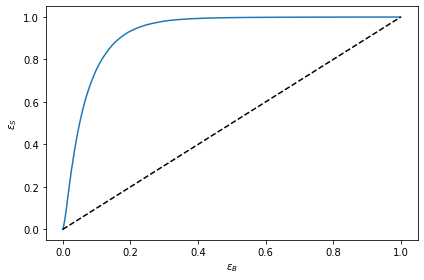

In [46]:
fpr, tpr, thresholds = roc_curve(y_true=targs2_2, y_score=preds2_2[:, 1])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], ls="--", color="k")
plt.xlabel(r"$\epsilon_B$")
plt.ylabel(r"$\epsilon_S$")
plt.tight_layout()

In [48]:
learn1.save('learn1_model')
learn1_1.save('learn1_1_model')
learn1_2.save('learn1_2_model')
learn2.save('learn2_model')
learn2_1.save('learn2_1_model')
learn2_2.save('learn2_2_model')

Path('models/learn2_2_model.pth')

In [49]:
def metrics(model, test):
    test_dl = model.dls.test_dl(test_items=test)
    preds, targs = model.get_preds(dl=test_dl)
    fpr, tpr, _ = roc_curve(y_true = targs, y_score=preds[:,1])
    acc_test = accuracy_score(targs, preds.argmax(dim=1))
    auc_test = auc(fpr, tpr)
    background_eff = interp1d(tpr, fpr)
    background_eff_at_30 = background_eff(0.3)
    
    print(f"Accuracy: {acc_test:.4f}")
    print(f"AUC: {auc_test:.4f}")
    print(
        f"Background rejection at signal efficiency 0.3: {1/background_eff_at_30:0.3f}"
    )
    
    return fpr, tpr

In [50]:
metrics(learn1, test_df)

Accuracy: 0.8521
AUC: 0.9205
Background rejection at signal efficiency 0.3: 45.890


(array([0.00000000e+00, 2.47630179e-05, 2.47630179e-05, ...,
        9.98335925e-01, 1.00000000e+00, 1.00000000e+00]),
 array([0.00000000e+00, 0.00000000e+00, 4.45354948e-05, ...,
        9.99995052e-01, 9.99995052e-01, 1.00000000e+00]))

In [71]:
metrics(learn1_1, test_df)

Accuracy: 0.5002
AUC: 0.5000
Background rejection at signal efficiency 0.3: 3.333


(array([0., 1.]), array([0., 1.]))

In [54]:
metrics(learn1_2, test_df)

Accuracy: 0.4998
AUC: 0.5000
Background rejection at signal efficiency 0.3: 3.333


(array([0., 1.]), array([0., 1.]))

In [51]:
metrics(learn2, test_df)

Accuracy: 0.4998
AUC: 0.5000
Background rejection at signal efficiency 0.3: 3.333


(array([0., 1.]), array([0., 1.]))

In [52]:
metrics(learn2_1, test_df)

Accuracy: 0.8115
AUC: 0.8855
Background rejection at signal efficiency 0.3: 27.535


(array([0.00000000e+00, 4.95260358e-06, 4.95260358e-06, ...,
        9.99975237e-01, 9.99975237e-01, 1.00000000e+00]),
 array([0.00000000e+00, 0.00000000e+00, 2.47419415e-05, ...,
        9.99995052e-01, 1.00000000e+00, 1.00000000e+00]))

In [53]:
metrics(learn2_2, test_df)

Accuracy: 0.8624
AUC: 0.9256
Background rejection at signal efficiency 0.3: 36.043


(array([0.00000000e+00, 1.23815090e-04, 1.33720297e-04, ...,
        9.99965332e-01, 9.99980190e-01, 1.00000000e+00]),
 array([0.00000000e+00, 5.93806597e-05, 1.08864543e-04, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]))